_ATU Donegal - MSc in Data Science: Machine Learning_
**<h1>Lab 3: Support Vector Machines</h1>**

Support Vector Machines are models which separate or *classify* data using a decision boundary. In simpler datasets the decision boundary can be a linear separator, but more complex boundaries can be found for more complex and noisier datasets. Let's first look at the simplest case of two clusters which are easily distinguishable. We use `make_blobs` to generate some sample clustered data.

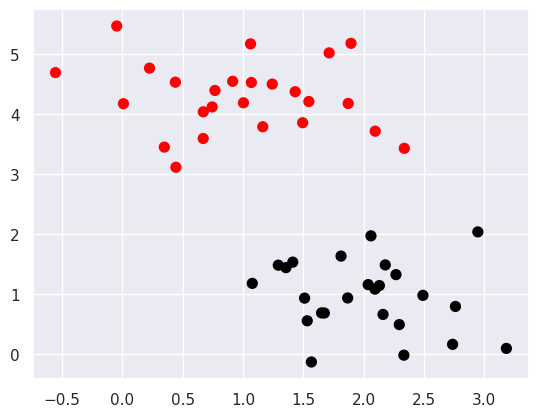

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()

from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='flag')


We use the `SVC` module in Scikitlearn to fit a support vector classifier to our data.

In [2]:
from sklearn.svm import SVC
model1 = SVC(kernel='linear', C=1E10)
model1.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Then we can plot the decision boundary with the margins and support vectors shown:

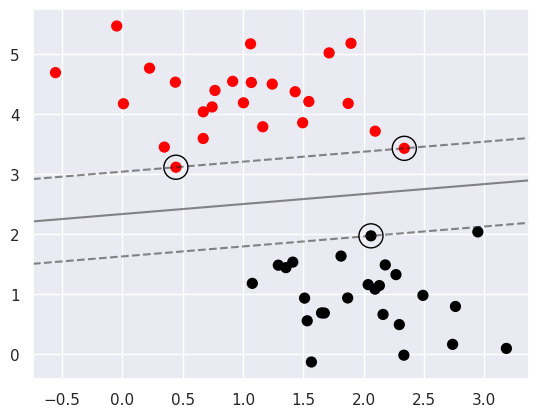

In [3]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 2)
    y = np.linspace(ylim[0], ylim[1], 2)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
      ax.scatter(model.support_vectors_[:,0],
                 model.support_vectors_[:,1],
                 s=300, linewidth=1, edgecolors='black', facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='flag')
plot_svc_decision_function(model1)

## Softening the Margin

Let's look at some data where we don't have such a clear separation. The margin softness can be tuned in this case depending on how tolerant we are of data lying within the margins. Let's first generate some data which is more intermixed:

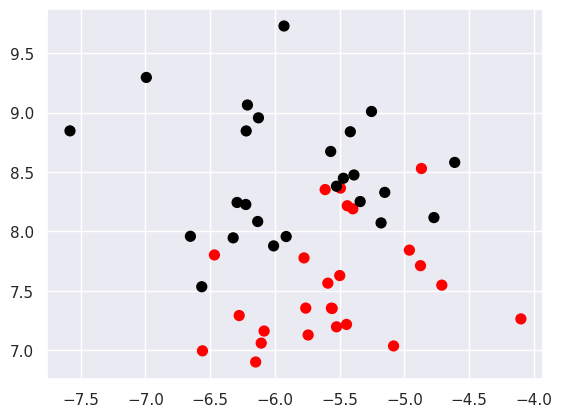

In [4]:
X2, y2 = make_blobs(n_samples=50, centers=2,
                  random_state=5, cluster_std=0.60)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='flag');

Let's see how the hard margin SVM does on this data:

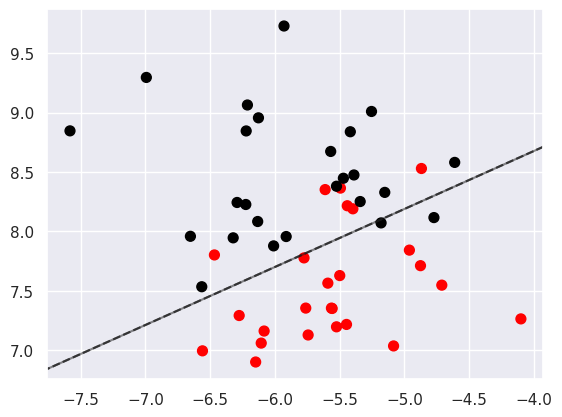

In [5]:
model2 = SVC(kernel='linear', C=1E10)
model2.fit(X2, y2)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='flag')
plot_svc_decision_function(model2, plot_support=False)


The hard margin formulation works as expected - there is no data between the separator and the margins. It's difficult to tell from the visualisation how a softer margin might affect our model, so we'll need to do some more work to determine this.

### Exercise
1. Create a train/test split, and then try changing the value of $C$ to see what effect this has on the model performance.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train,X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [7]:
from random import random
import numpy as np

for i in np.arange(1,10,0.1):
  val = round(i,1)
  svc_model = SVC(kernel='linear', C=val)
  svc_model.fit(X_train,y_train)
  y_pred = svc_model.predict(X_test)

  print(f"C = {val} accuracy = {accuracy_score(y_test,y_pred)}")
  print("________________________________________________________")

C = 1.0 accuracy = 1.0
________________________________________________________
C = 1.1 accuracy = 1.0
________________________________________________________
C = 1.2 accuracy = 1.0
________________________________________________________
C = 1.3 accuracy = 1.0
________________________________________________________
C = 1.4 accuracy = 1.0
________________________________________________________
C = 1.5 accuracy = 1.0
________________________________________________________
C = 1.6 accuracy = 1.0
________________________________________________________
C = 1.7 accuracy = 1.0
________________________________________________________
C = 1.8 accuracy = 1.0
________________________________________________________
C = 1.9 accuracy = 1.0
________________________________________________________
C = 2.0 accuracy = 1.0
________________________________________________________
C = 2.1 accuracy = 1.0
________________________________________________________
C = 2.2 accuracy = 1.0
_________________

## Multiple Clusters

We can also use SVMs for distinguishing multiple clusters. Let's create some income/age clustered data that we can use for this.

In [8]:
import numpy as np

#Create income/age clusters for N people in k clusters
def create_clustered_data(N, k):
    np.random.seed(2)

    points_per_cluster = float(N)/k
    X = []
    y = []
    for i in range (k):
        income_centroid = np.random.uniform(20000.0, 200000.0)
        age_centroid = np.random.uniform(20.0, 70.0)
        for j in range(int(points_per_cluster)):
            X.append([np.random.normal(income_centroid, 10000.0),
                      np.random.normal(age_centroid, 2.0)])
            y.append(i)
    X = np.array(X)
    y = np.array(y)
    return X, y

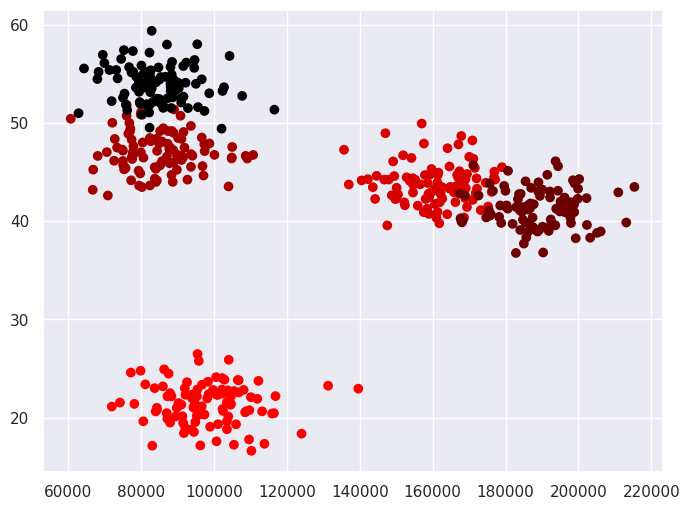

In [9]:
import matplotlib.pyplot as plt

(X, y) = create_clustered_data(500, 5)

plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], c=y.astype(float), cmap='flag')
plt.show()

Now we'll use a linear SVC to partition our data into clusters:

In [10]:
from sklearn import svm, datasets

C = 1.0
svc = svm.SVC(C=C, kernel='linear').fit(X, y)

Remember that the Scikit Learn documentation is a great source of information for all the models we're using. For <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html" target="_blank">`svm.SVC`</a> it states "The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples. For large datasets consider using `LinearSVC` or `SGDClassifier` instead...". If the fit method runs very slowly it may be worth trying the quicker linear variant, although it can be trickier to achieve convergence.

By setting up a dense mesh of points in the grid and classifying all of them, we can render the regions of each cluster as distinct colors:

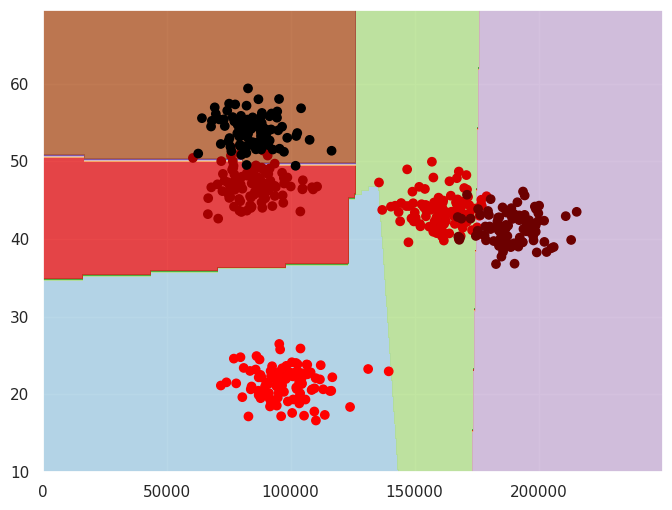

In [11]:
def plot_predictions(clf):
    xx, yy = np.meshgrid(np.arange(0, 250000, 10),
                     np.arange(10, 70, 0.5))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(8, 6))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:,0], X[:,1], c=y.astype(float), cmap='flag')
    plt.show()

plot_predictions(svc)

To find the predicted class/cluster label for a particular sample of age/income data, we just use `predict` for a given point:

In [12]:
print(svc.predict([[200000, 40]]), svc.predict([[50000, 65]]))

[3] [4]


## Exercises

##### 2."Linear" is one of many kernels scikit-learn supports on SVC. Look up the documentation for Scikit-learn to find out what the other possible kernel options are. Do any of them work well for this data set? As usual you should use an appropriate test-train split to determine your answer.*

In [22]:
# X_train,X_test, y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
# kern = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
kern = ['linear', 'poly', 'rbf', 'sigmoid']


for k in kern:
  svc_model1 = SVC(kernel=k, C=val)
  svc_model1.fit(X_train,y_train)
  y_pred = svc_model1.predict(X_test)

  print(f"Kernel = {k} -------------- accuracy = {accuracy_score(y_test,y_pred)}")
  print("__________________________________________________")

Kernel = linear -------------- accuracy = 0.9609756097560975
__________________________________________________
Kernel = poly -------------- accuracy = 0.9658536585365853
__________________________________________________
Kernel = rbf -------------- accuracy = 0.9658536585365853
__________________________________________________
Kernel = sigmoid -------------- accuracy = 0.2682926829268293
__________________________________________________


## SVM Model for Cancer Classification

To finish up this lab, we'll look at a more sophisticated dataset containing information on cell samples, with the aim of classifying whether or not they are cancerous. The data is available from  the <a href="http://mlearn.ics.uci.edu/MLRepository.html" target="_blank"> UCI Machine Learning Repository</a>. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The columns in the dataset are as follows:
<center>

|Field name|Description|
|--- |--- |
|ID|Sample ID|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

</center>

First we download the data and import it as a Pandas data frame.

In [14]:
!wget -O cell_samples.csv https://raw.githubusercontent.com/paulgreaney/data/main/cell_samples.csv

import pandas as pd
cell_data = pd.read_csv("cell_samples.csv")
cell_data.head()

--2024-02-09 14:52:22--  https://raw.githubusercontent.com/paulgreaney/data/main/cell_samples.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20675 (20K) [text/plain]
Saving to: ‘cell_samples.csv’

cell_samples.csv    100%[===================>]  20.19K  --.-KB/s    in 0s      

2024-02-09 14:52:22 (120 MB/s) - ‘cell_samples.csv’ saved [20675/20675]



,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [15]:
cell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           699 non-null    int64 
 1   Clump        699 non-null    int64 
 2   UnifSize     699 non-null    int64 
 3   UnifShape    699 non-null    int64 
 4   MargAdh      699 non-null    int64 
 5   SingEpiSize  699 non-null    int64 
 6   BareNuc      699 non-null    object
 7   BlandChrom   699 non-null    int64 
 8   NormNucl     699 non-null    int64 
 9   Mit          699 non-null    int64 
 10  Class        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


There appears to be something off in the `BareNuc` column, as the data type is different. Let's look at the values to see:

In [16]:
cell_data['BareNuc'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

We see the data is encoded as strings, with missing information recorded as `'?'`. We can fix this using the Pandas `to_numeric` function, passing `errors='coerce'` so that invalid parsing will be set as NaN, then removing the NaNs with `.notnull()` and casting the data to integer type to match the remaining columns.

In [17]:
cell_data = cell_data[pd.to_numeric(cell_data['BareNuc'], errors='coerce').notnull()]
cell_data['BareNuc'] = cell_data['BareNuc'].astype('int')
cell_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           683 non-null    int64
 1   Clump        683 non-null    int64
 2   UnifSize     683 non-null    int64
 3   UnifShape    683 non-null    int64
 4   MargAdh      683 non-null    int64
 5   SingEpiSize  683 non-null    int64
 6   BareNuc      683 non-null    int64
 7   BlandChrom   683 non-null    int64
 8   NormNucl     683 non-null    int64
 9   Mit          683 non-null    int64
 10  Class        683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB


<ipython-input-17-eb4fca190579>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data['BareNuc'] = cell_data['BareNuc'].astype('int')


Next we select the features we want to use as predictors in our SVM model:

In [18]:
feature_data = cell_data[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_data)
y = np.asarray(cell_data['Class'])

In [19]:
cell_data.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


#### Exercise
3. Your task is to find the best performing SVM model by creating a train-test split and tuning the hyperparameters of the model. Use `ConfusionMatrixDisplay` from `sklearn.metrics` to produce a normalised confusion matrix showing your results.*

Kernel = linear -------------- accuracy = 0.9609756097560975


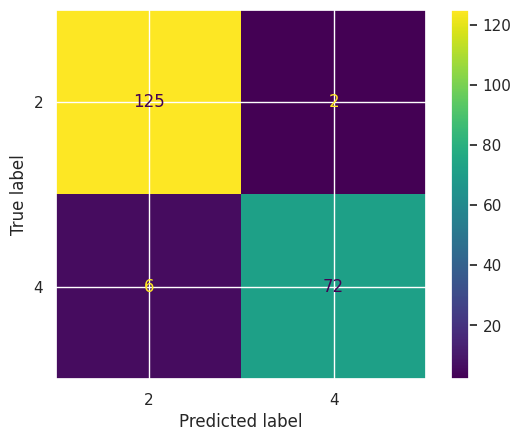

Kernel = poly -------------- accuracy = 0.9658536585365853


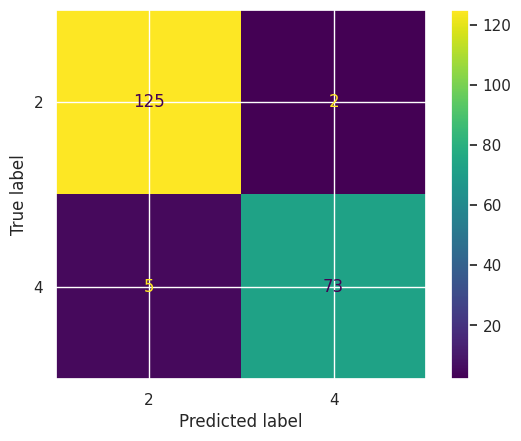

Kernel = rbf -------------- accuracy = 0.9658536585365853


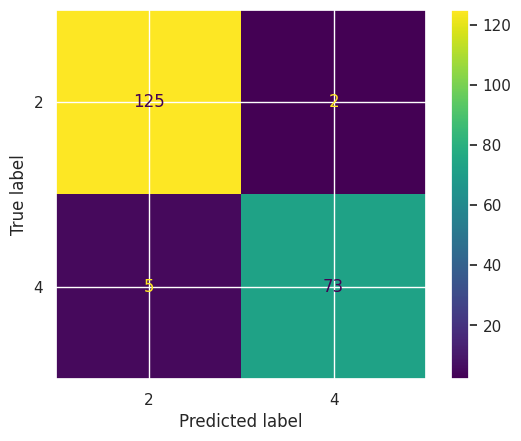

Kernel = sigmoid -------------- accuracy = 0.2682926829268293


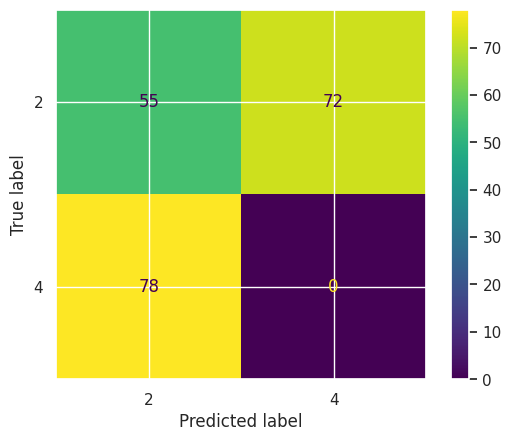

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


X_train,X_test, y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
# kern = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
kern = ['linear', 'poly', 'rbf', 'sigmoid']


for k in kern:
  svc_model2 = SVC(kernel=k, C=val)
  svc_model2.fit(X_train,y_train)
  y_pred = svc_model2.predict(X_test)
  cm = confusion_matrix(y_test,y_pred, labels = svc_model2.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels = svc_model2.classes_)
  print(f"Kernel = {k} -------------- accuracy = {accuracy_score(y_test,y_pred)}")
  disp.plot()
  plt.show()

C = 10.0 -------------- accuracy = 0.9658536585365853


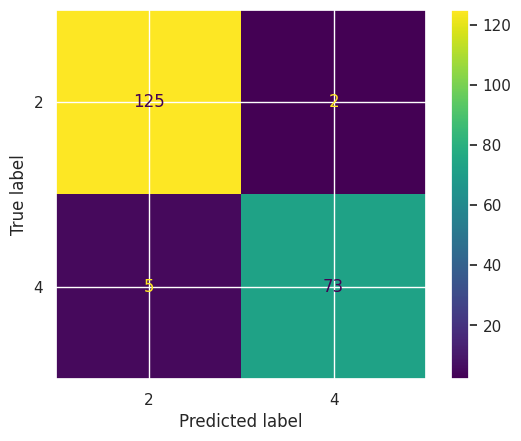

C = 10.8 -------------- accuracy = 0.9658536585365853


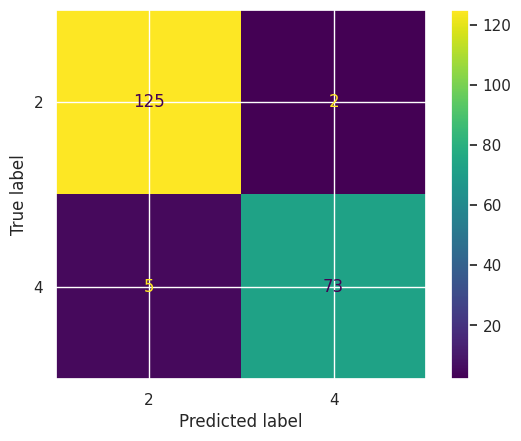

C = 11.6 -------------- accuracy = 0.9707317073170731


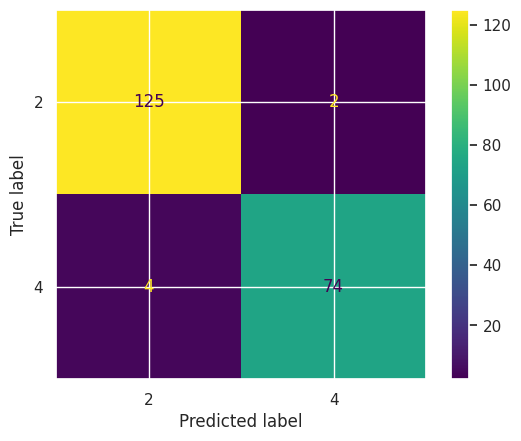

C = 12.4 -------------- accuracy = 0.9707317073170731


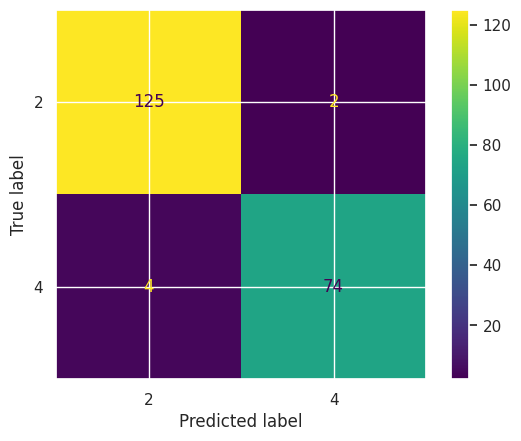

C = 13.2 -------------- accuracy = 0.9707317073170731


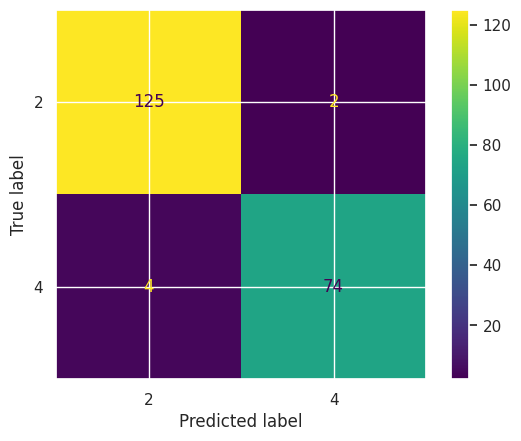

C = 14.0 -------------- accuracy = 0.9707317073170731


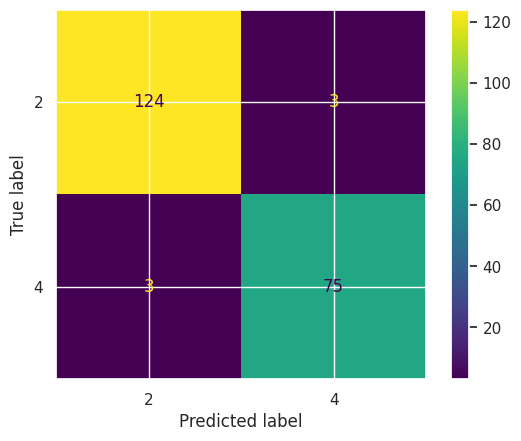

C = 14.8 -------------- accuracy = 0.9707317073170731


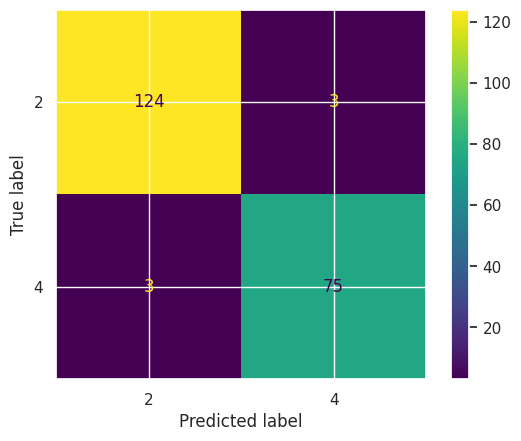

C = 15.6 -------------- accuracy = 0.9707317073170731


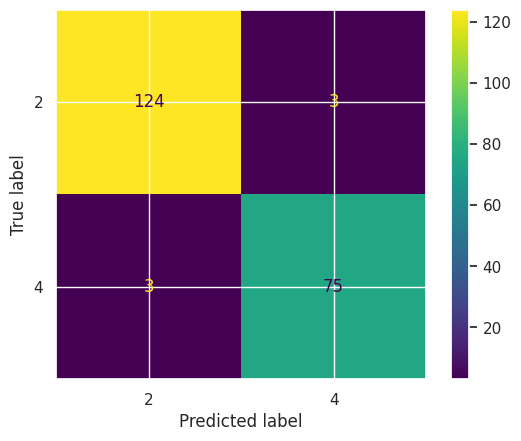

C = 16.4 -------------- accuracy = 0.9707317073170731


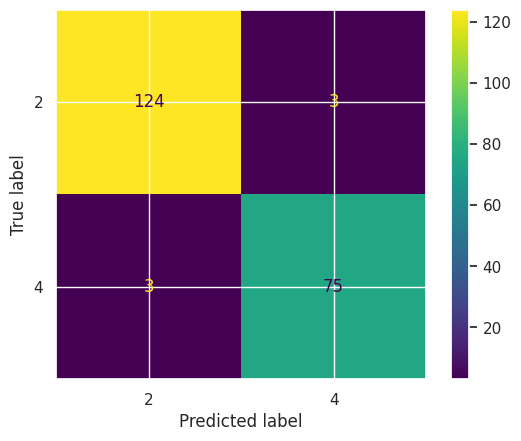

C = 17.2 -------------- accuracy = 0.9707317073170731


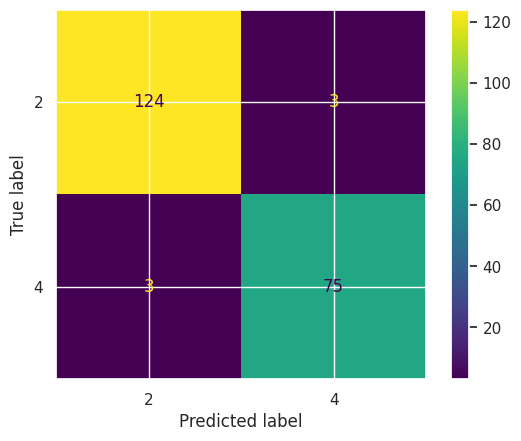

C = 18.0 -------------- accuracy = 0.9707317073170731


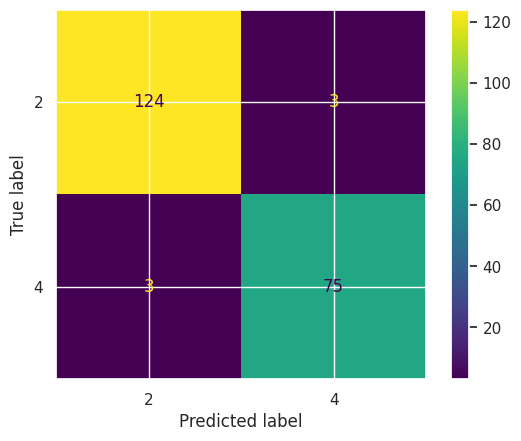

C = 18.8 -------------- accuracy = 0.9707317073170731


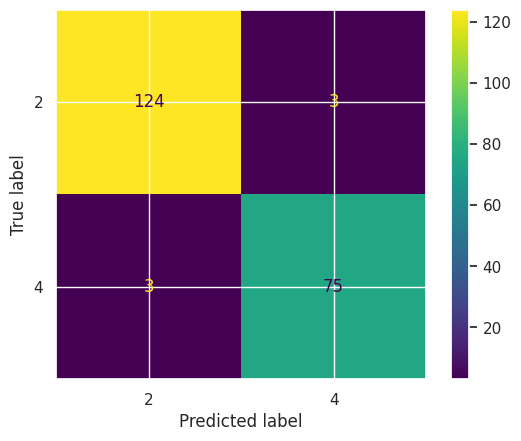

C = 19.6 -------------- accuracy = 0.9707317073170731


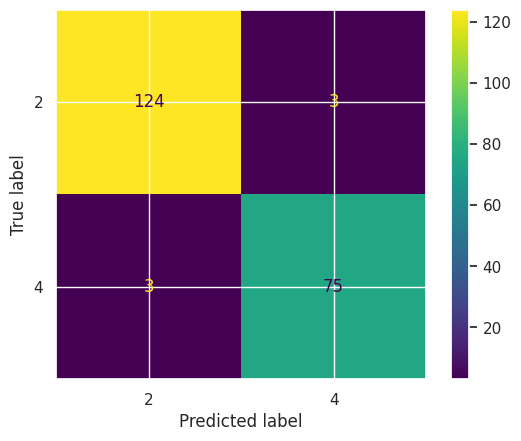

C = 20.4 -------------- accuracy = 0.9707317073170731


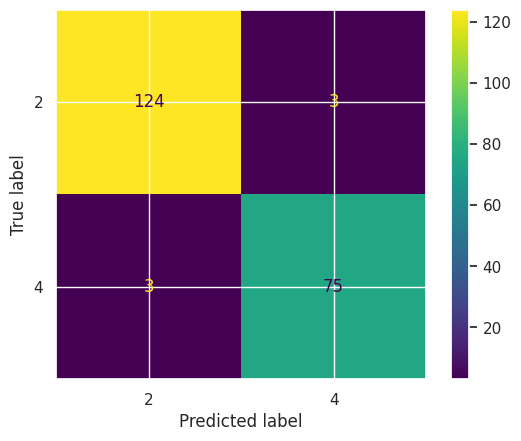

C = 21.2 -------------- accuracy = 0.9707317073170731


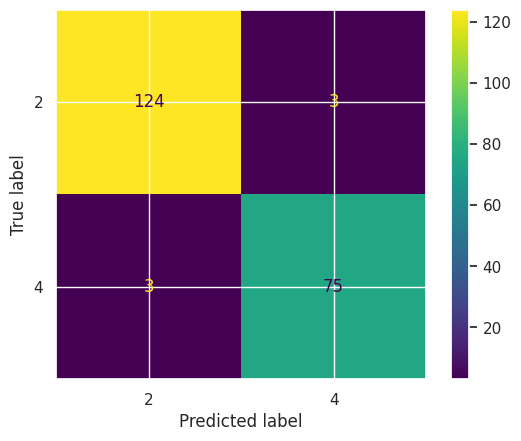

C = 22.0 -------------- accuracy = 0.9707317073170731


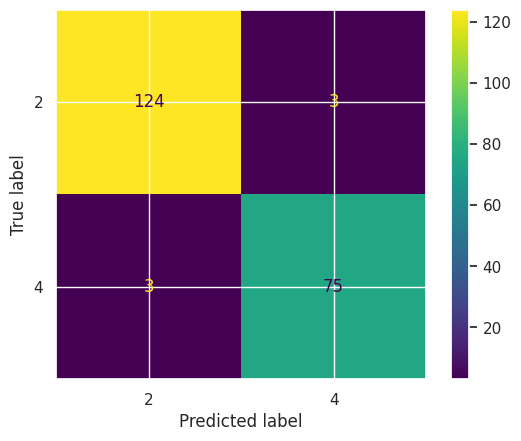

C = 22.8 -------------- accuracy = 0.9707317073170731


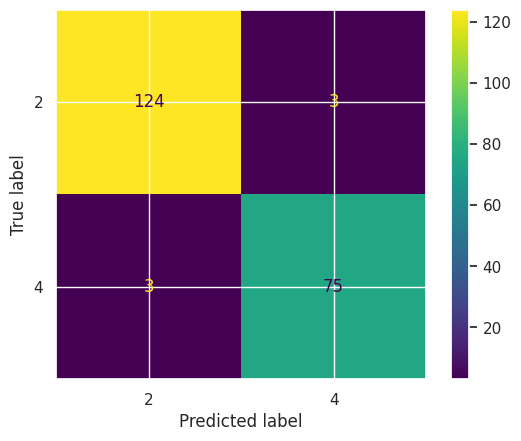

C = 23.6 -------------- accuracy = 0.9707317073170731


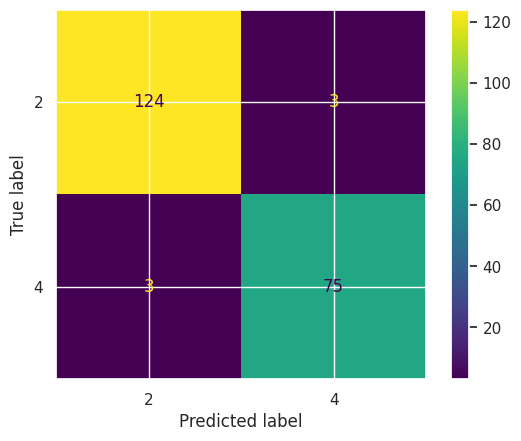

C = 24.4 -------------- accuracy = 0.9707317073170731


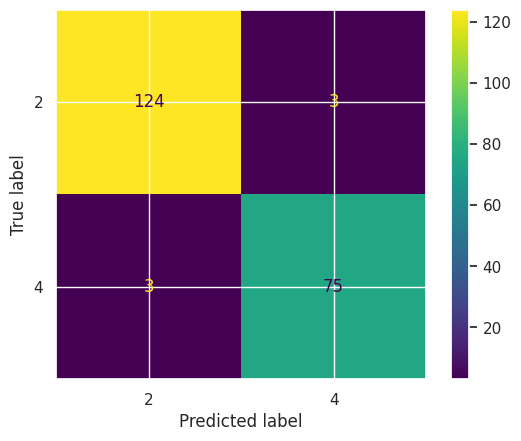

C = 25.2 -------------- accuracy = 0.9707317073170731


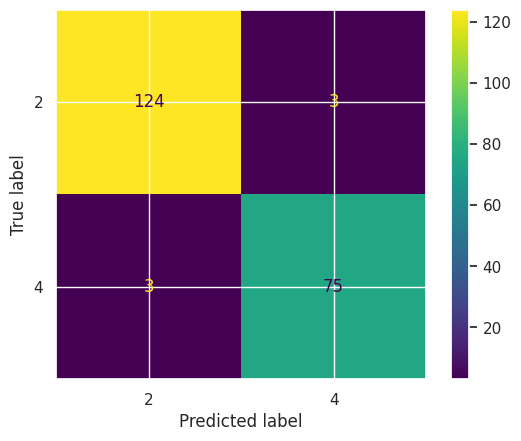

C = 26.0 -------------- accuracy = 0.9658536585365853


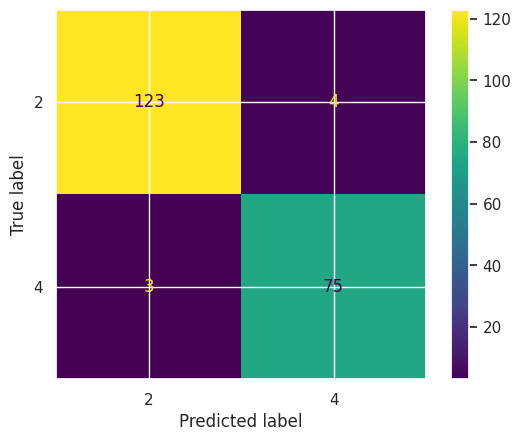

C = 26.8 -------------- accuracy = 0.9609756097560975


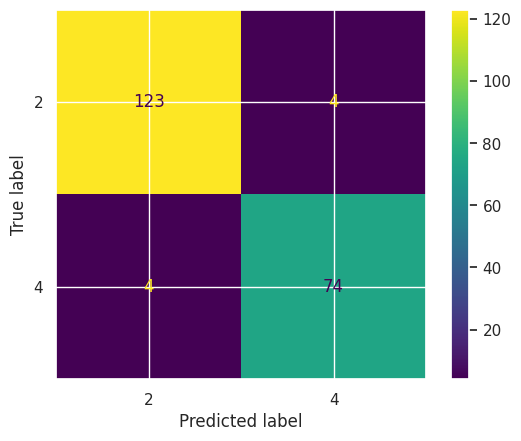

C = 27.6 -------------- accuracy = 0.9609756097560975


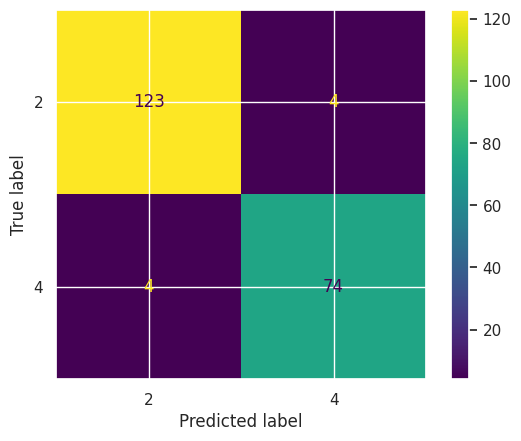

C = 28.4 -------------- accuracy = 0.9609756097560975


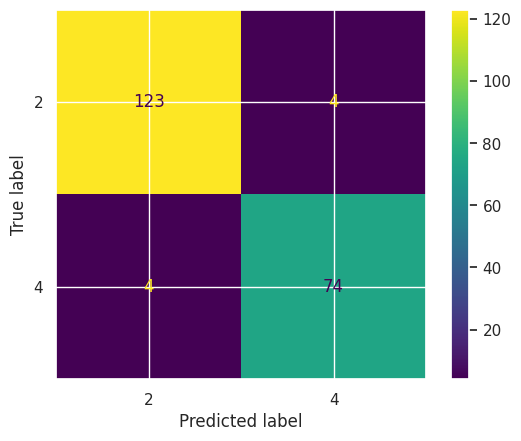

C = 29.2 -------------- accuracy = 0.9609756097560975


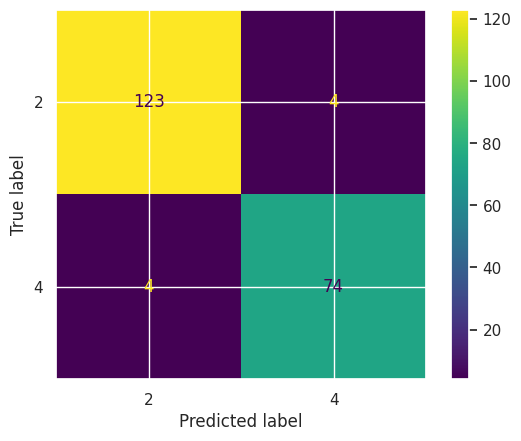

In [27]:
for i in np.arange(10,30,0.8):
  val = round(i,1)
  svc_model2 = SVC(kernel='rbf', C=val)

  svc_model2.fit(X_train,y_train)
  y_pred = svc_model2.predict(X_test)
  cm = confusion_matrix(y_test,y_pred, labels = svc_model2.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels = svc_model2.classes_)
  print(f"C = {val} -------------- accuracy = {accuracy_score(y_test,y_pred)}")
  disp.plot()
  plt.show()

Accuracy = 0.9707317073170731


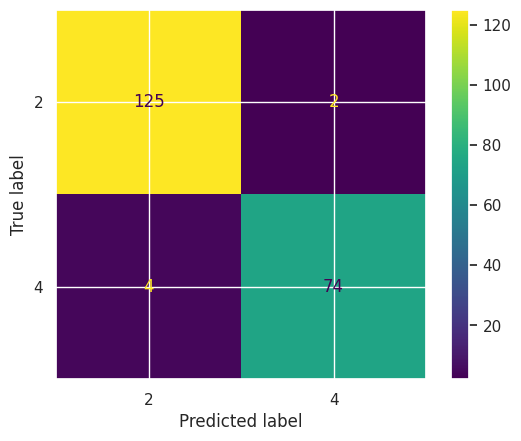

In [30]:
svc_model_final = SVC(kernel='rbf', C=11.6)

svc_model_final.fit(X_train,y_train)
y_pred = svc_model_final.predict(X_test)
cm = confusion_matrix(y_test,y_pred, labels = svc_model_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = svc_model_final.classes_)
print(f"Accuracy = {accuracy_score(y_test,y_pred)}")
disp.plot()
plt.show()

### Assessment
To get the marks for this lab, you should show your solution to exercises 2 and 3 to the lecturer.